# Data evaluation

INFO:

Some light is observed by the confocal device, irrespective its environment. This light is reasonably consistent so it was treated as a systematic error. To mitigate, the device has a built-in feature that removes the false observations. This is the difference between 'Dark' and 'Raw' spectra. Therefore, Dark data is primarily used in this file. 

The intensity of respective wavelengths was not even. This was mitigated for via the dark_spectra.csv and raw_spectra.csv files in the Adjusters file. This contains the emiited wavelength intensity distribution. 

Emmitted wavelengths are not evenly distrirbuted with respect to the position they measure. This is mitigated for via the spectra_accel.csv file. 

In [411]:
# IMPORTS

import numpy as np
import math
import matplotlib.pyplot as plt

import matplotlib.ticker as tck
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import glob
from glob import glob
import time
from PIL import Image

sns.set_theme()

## Setup Variables

In [412]:
datapath = 'DATA37N'
adjusterspath = 'Adjusters'

scale = 1                      #Angle increments
sensor_range = 2.65            #Measurement range 

## Get & Organise Data

In [413]:
filename = glob(datapath + '/*.csv')[0] #grab random data file
csv_path = glob(datapath + '/*.csv')    #grab ALL data files
csv_path.sort()

#raw spectra file
raw_adjuster_path = pd.read_csv(adjusterspath + '/raw_spectra.csv', names=['Column1', 'Column2'])
x_raw_spectra = raw_adjuster_path['Column1'][:]
y_raw_spectra = raw_adjuster_path['Column2'][:]
raw_spectra_max = max(y_raw_spectra)
raw_spectra_adj = [val / raw_spectra_max for val in y_raw_spectra]
raw_spectra_adj[:] = [1/val for val in raw_spectra_adj]

#dark spectra file
dark_adjuster_path = pd.read_csv(adjusterspath + '/dark_spectra.csv', names=['Column1', 'Column2'])
x_dark_spectra = dark_adjuster_path['Column1'][:]
y_dark_spectra = dark_adjuster_path['Column2'][:]
dark_spectra_max = max(y_dark_spectra)
dark_spectra_adj = [val / dark_spectra_max for val in y_dark_spectra]
dark_spectra_adj[:] = [1/val for val in dark_spectra_adj]

#adjuster file
af = pd.read_csv(adjusterspath + '/spectra_accel.csv', names=['Column1','Column2'])
range_points = af['Column1'][:]
physical_points = af['Column2'][:]

## Plot spectrum adjuster

This illustrates the emitted wavelength intensity distribution, in addition to its inverted values (which are used to multiply measurements).

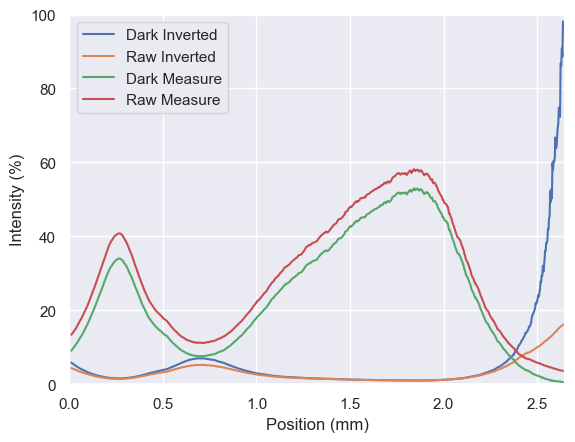

In [414]:
plt.plot(physical_points, dark_spectra_adj, label='Dark Inverted')
plt.plot(physical_points, raw_spectra_adj, label='Raw Inverted')
plt.plot(physical_points, y_dark_spectra, label='Dark Measure')
plt.plot(physical_points, y_raw_spectra, label='Raw Measure')
plt.legend(loc="upper left")
plt.xlabel('Position (mm)')
plt.ylabel('Intensity (%)')
plt.xlim(0,2.65)
plt.ylim(0,100)
#plt.savefig(datapath + '/Evaluations/spectra_adj.svg', dpi=600)         #spectra adjustment plot
plt.show()

## Raw & Dark Spectra plot

Plot of all data for both Raw and Dark measurements. 

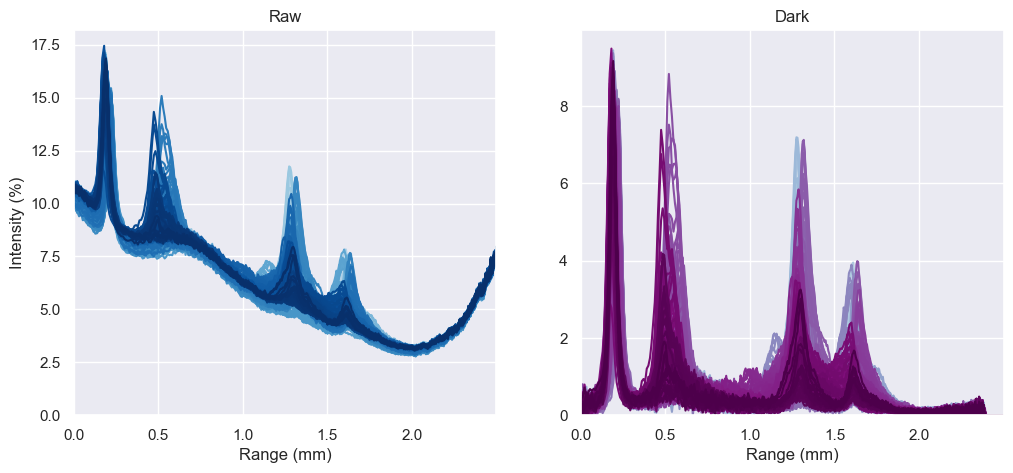

In [415]:
fig, ax = plt.subplots(1, 2, sharex=True)

ax[0].set_prop_cycle('color', list(plt.cm.Blues(np.linspace(0.3, 1, len(csv_path)))))   
ax[1].set_prop_cycle('color', list(plt.cm.BuPu(np.linspace(0.3, 1, len(csv_path)))))

all_peaks = [] 
peak_nums_at_given_angle = []
for i, f in enumerate(csv_path):
    #print("Processing file:", f)
    df = pd.read_csv(f, names=['Raw', 'Dark'])
    y_raw = df['Raw'][:]/203.8
    y_dark = df['Dark'][:]/203.8
    np.clip(y_raw, 0, 100, inplace=True) #clip values to 0-100 : sometimes poor data is returned (~18000)
    np.clip(y_dark, 0, 100, inplace=True)
    y_raw[:] = [a * b for a, b in zip(y_raw, raw_spectra_adj)]
    y_dark[:] = [a * b for a, b in zip(y_dark, dark_spectra_adj)] #adjust intensity

    #gets peak positions for later use
    peaks, _ = find_peaks(y_dark, height=[0.7, None], prominence=[0.6, None], width=[0.8, None])
    all_peaks.append(peaks)
    peak_nums_at_given_angle.append(len(peaks))

    ax[0].plot(physical_points, y_raw)
    ax[1].plot(physical_points, y_dark)

ax[0].set_xlabel('Range (mm)') 
ax[0].set_ylabel('Intensity (%)')
ax[0].set_ylim(0,)
ax[0].set_title('Raw')

ax[1].set_xlabel('Range (mm)')
ax[1].set_xlim(0,2.5)
ax[1].set_xticks(np.arange(0,2.5,0.5))
ax[1].set_ylim(0,)
ax[1].set_title('Dark')

fig.set_size_inches(12,5)

## Waterfall Plot

Actually a scatter plot, used to compare the angle and material interface measurement for the Dark data only. 

Peaks are identified using the find_peaks function from scipy.signal

Empty space before spectra:   0.16008 mm


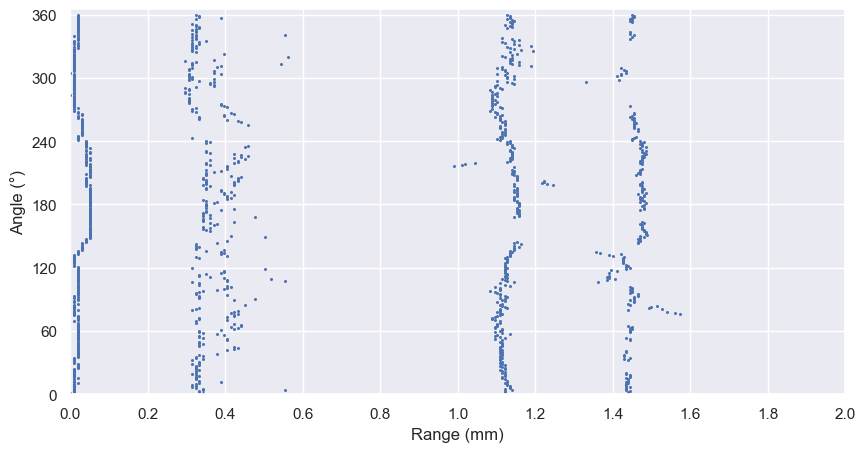

In [416]:
#xpos
dividor = 512 / sensor_range
peak_xpos_1D = []
for sub_array in all_peaks:
    for number in sub_array:
        peak_xpos_1D.append(number)

peak_xpos_1D[:] = [x/dividor for x in peak_xpos_1D]
peak_xpos_1D[:] = [0.1055*x*x*x -0.7024*x*x + 2.1158*x for x in peak_xpos_1D] #accounts for 'spectra acceleration'

min_x = min(peak_xpos_1D)
min_x_rnd = str(round(min_x, 5))
print('Empty space before spectra:  ',min_x_rnd, 'mm')
peak_xpos_1D[:] = [x - min_x for x in peak_xpos_1D]

#degs/rads
i=1
peak_degs_1D = []
while i <= len(peak_nums_at_given_angle):
    num = peak_nums_at_given_angle[i-1]
    num_temp = num
    while num_temp > 0:
        peak_degs_1D.append(i)
        num_temp = num_temp -1
    i = i + 1

peak_degs_1D[:] = [x * scale for x in peak_degs_1D] #no of measurements into degrees. 
peak_rads_1D = [x * np.pi/180 for x in peak_degs_1D]

plt.figure(figsize=(10,5))
plt.scatter(peak_xpos_1D,peak_degs_1D, s=1.4)
plt.xlabel('Range (mm)')
plt.ylabel('Angle (°)')
plt.yticks(np.arange(0, 361, step=60))
plt.ylim(0,365)
plt.xticks(np.arange(0, 3, step=0.2))
plt.xlim(0,2)
#plt.savefig(datapath + '/Evaluations/waterfall.svg')
plt.show()

## Polar plot of specified peaks


Diameter of microtubing: 1.4797 mm
Radius of microtubing:   0.73985 mm


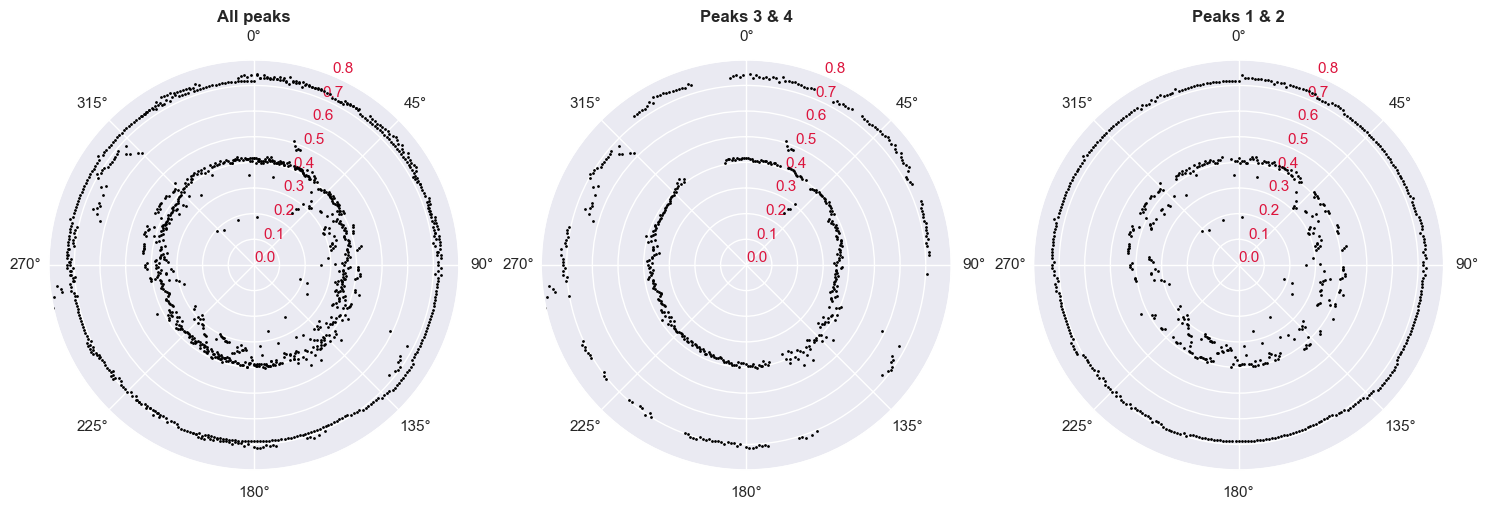

In [417]:
sorted_peak_xpos_1D = sorted(peak_xpos_1D)
avg = (sorted_peak_xpos_1D[-20])/2
avg_rnd = str(round(avg, 5))
print('Diameter of microtubing:', round(sorted_peak_xpos_1D[-20], 5), 'mm\nRadius of microtubing:  ', avg_rnd, 'mm')

peak_rads_1D_1234 = []
for i, value in enumerate(peak_xpos_1D):
  if value < avg:
    peak_rads_1D_1234.append(peak_rads_1D[i] + np.pi)
  else:
    peak_rads_1D_1234.append(peak_rads_1D[i])
peak_xpos_1D_1234 = peak_xpos_1D[:]


fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'))

peak_xpos_1D_1234[:] = [x - avg for x in peak_xpos_1D_1234]
peak_xpos_1D_1234[:] = [-i if i <0 else i for i in peak_xpos_1D_1234]
peak_rads_1D_1234[:] = [i + np.pi for i in peak_rads_1D_1234]

ax[0].plot(peak_rads_1D_1234, peak_xpos_1D_1234, linestyle = 'None', color='black', marker='.', markersize='2', markerfacecolor='black')
ax[0].set_theta_zero_location('N')
ax[0].set_theta_direction(-1) # anticlockwise
ax[0].grid(True)
ax[0].tick_params(axis='y', colors='crimson')
ax[0].figure.set_size_inches(6,6)
ax[0].set_yticks(np.arange(0,1.1,0.1))
ax[0].set_ylim(0,0.8)
ax[0].set_title('All peaks', fontweight='bold')
#plt.savefig(datapath + '/Evaluations/visual.svg')


peak_xpos_1D_34 = [x - avg for x in peak_xpos_1D if x >= 0.8]
peak_rads_1D_34 = [peak_rads_1D[i] for i, x in enumerate(peak_xpos_1D) if x >= 0.8]
peak_rads_1D_34 = [i + np.pi for i in peak_rads_1D_34]

ax[1].plot(peak_rads_1D_34, peak_xpos_1D_34, linestyle = 'None', color='black', marker='.', markersize='2', markerfacecolor='black')
ax[1].set_theta_zero_location('N')
ax[1].set_theta_direction(-1) # clockwise
ax[1].grid(True)
ax[1].tick_params(axis='y', colors='crimson')
ax[1].set_yticks(np.arange(0,1.1,0.1))
ax[1].set_ylim(0,0.8)
ax[1].set_title('Peaks 3 & 4', fontweight='bold')
#plt.savefig(datapath + '/Evaluations/visual_p34.svg')


peak_xpos_1D_12 = [x - avg for x in peak_xpos_1D if x <= avg]
peak_xpos_1D_12 = [-i for i in peak_xpos_1D_12]
peak_rads_1D_12 = [peak_rads_1D[i] for i, x in enumerate(peak_xpos_1D) if x <= avg]
#peak_rads_1D_12[:] = [i + np.pi for i in peak_rads_1D_12]

ax[2].plot(peak_rads_1D_12, peak_xpos_1D_12, linestyle = 'None', color='black', marker='.', markersize='2', markerfacecolor='black')
ax[2].set_theta_zero_location('N')
ax[2].set_theta_direction(-1) # clockwise
ax[2].grid(True)
ax[2].tick_params(axis='y', colors='crimson')
ax[2].set_yticks(np.arange(0,1.1,0.1))
ax[2].set_ylim(0,0.8)
ax[2].set_title('Peaks 1 & 2', fontweight='bold')
#plt.savefig(datapath + '/Evaluations/visual_p12.svg')

fig.set_size_inches(18,10)


## Waterfall plot of peaks 1 & 2

Again, actually a scatter plot. The first plot is unadjusted, the second removes outliers, and the third removes outliers & forms a moving average. 

In [418]:
#Remove outliers. 
mean_12 = np.mean(peak_xpos_1D_12)

peak_xpos_1D_p2 = [i for i in peak_xpos_1D_12 if i<mean_12]
q1_p2 = np.percentile(peak_xpos_1D_p2, 25)
q3_p2 = np.percentile(peak_xpos_1D_p2, 75)
iqr_p2 = q3_p2 - q1_p2
lwr_bou_p2 = q1_p2 - 1.5 * iqr_p2
upp_bou_p2 = q3_p2 + 1.5 * iqr_p2

peak_xpos_1D_p1 = [i for i in peak_xpos_1D_12 if i>mean_12]
q1_p1 = np.percentile(peak_xpos_1D_p1, 25)
q3_p1 = np.percentile(peak_xpos_1D_p1, 75)
iqr_p1 = q3_p1 - q1_p1
lwr_bou_p1 = q1_p1 - 1.5 * iqr_p1
upp_bou_p1 = q3_p1 + 1.5 * iqr_p1

peak_xpos_1D_12_no_outliers = peak_xpos_1D_12.copy()
peak_rads_1D_12_no_outliers = peak_rads_1D_12.copy()
for i, val in enumerate(peak_xpos_1D_12_no_outliers):
    if val < lwr_bou_p2:
        peak_xpos_1D_12_no_outliers.pop(i)
        peak_rads_1D_12_no_outliers.pop(i)
    if val > upp_bou_p1:
        peak_xpos_1D_12_no_outliers.pop(i)
        peak_rads_1D_12_no_outliers.pop(i)
    if upp_bou_p2 < val < lwr_bou_p1:
        peak_xpos_1D_12_no_outliers.pop(i)
        peak_rads_1D_12_no_outliers.pop(i)

In [419]:
#Create moving average.
mean_12 = np.mean(peak_xpos_1D_12_no_outliers)
peak_xpos_1D_p2 = [x for x in peak_xpos_1D_12_no_outliers if x<mean_12]
peak_xpos_1D_p1 = [x for x in peak_xpos_1D_12_no_outliers if x>mean_12]
peak_rads_1D_p2 = [peak_rads_1D_12_no_outliers[i] for i, x in enumerate(peak_xpos_1D_12_no_outliers) if x<mean_12]
peak_rads_1D_p1 = [peak_rads_1D_12_no_outliers[i] for i, x in enumerate(peak_xpos_1D_12_no_outliers) if x>mean_12]

window_size = int(11)   #MUST BE ODD & >3
window_shift = (window_size-1)/2
peak_xpos_1D_p2_extended = peak_xpos_1D_p2.copy()
peak_xpos_1D_p1_extended = peak_xpos_1D_p1.copy()
for p in range(int(window_shift)):
    peak_xpos_1D_p2_extended.insert(0, peak_xpos_1D_p2[-p-1])
    peak_xpos_1D_p1_extended.insert(0, peak_xpos_1D_p1[-p-1])
    peak_xpos_1D_p2_extended.append(peak_xpos_1D_p2[p])
    peak_xpos_1D_p1_extended.append(peak_xpos_1D_p1[p])

i = 0
peak_xpos_1D_p2_moving_average = []
while i < len(peak_xpos_1D_p2_extended) - window_size + 1:
    window = peak_xpos_1D_p2_extended[i:i+window_size]
    window_average = round(sum(window) / window_size, 2)
    peak_xpos_1D_p2_moving_average.append(window_average)
    i += 1

i = 0
peak_xpos_1D_p1_moving_average = []
while i < len(peak_xpos_1D_p1_extended) - window_size + 1:
    window = peak_xpos_1D_p1_extended[i:i+window_size]
    window_average = round(sum(window) / window_size, 2)
    peak_xpos_1D_p1_moving_average.append(window_average)
    i += 1

peak_xpos_1D_12_moving_average = np.concatenate((peak_xpos_1D_p1_moving_average,peak_xpos_1D_p2_moving_average))
peak_rads_1D_12_moving_average = np.concatenate((peak_rads_1D_p1,peak_rads_1D_p2))


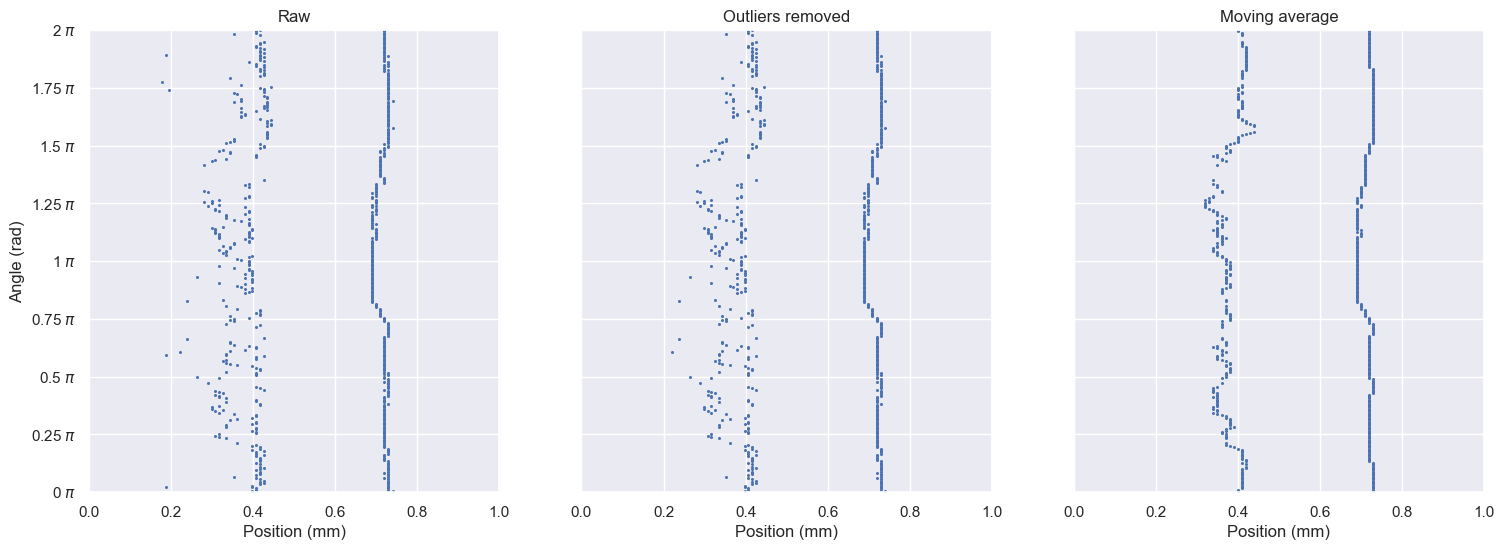

In [420]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)

ax[0].yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax[0].yaxis.set_major_locator(tck.MultipleLocator(base=0.25))
ax[0].set_ylim(0,2)
ax[0].set_xlim(0,1)
ax[0].set_ylabel('Angle (rad)')
ax[0].set_title('Raw')
ax[1].set_title('Outliers removed')
ax[2].set_title('Moving average')
ax[0].set_xlabel('Position (mm)')
ax[1].set_xlabel('Position (mm)')
ax[2].set_xlabel('Position (mm)')

# /np.pi to account for labelling difference
ax[0].scatter(peak_xpos_1D_12, [x/np.pi for x in peak_rads_1D_12], s=1.4)
ax[1].scatter(peak_xpos_1D_12_no_outliers, [x/np.pi for x in peak_rads_1D_12_no_outliers], s=1.4)
ax[2].scatter(peak_xpos_1D_12_moving_average, [x/np.pi for x in peak_rads_1D_12_moving_average], s=1.4)

fig.set_size_inches(18,6)

## Polar plot of adjusted data. 

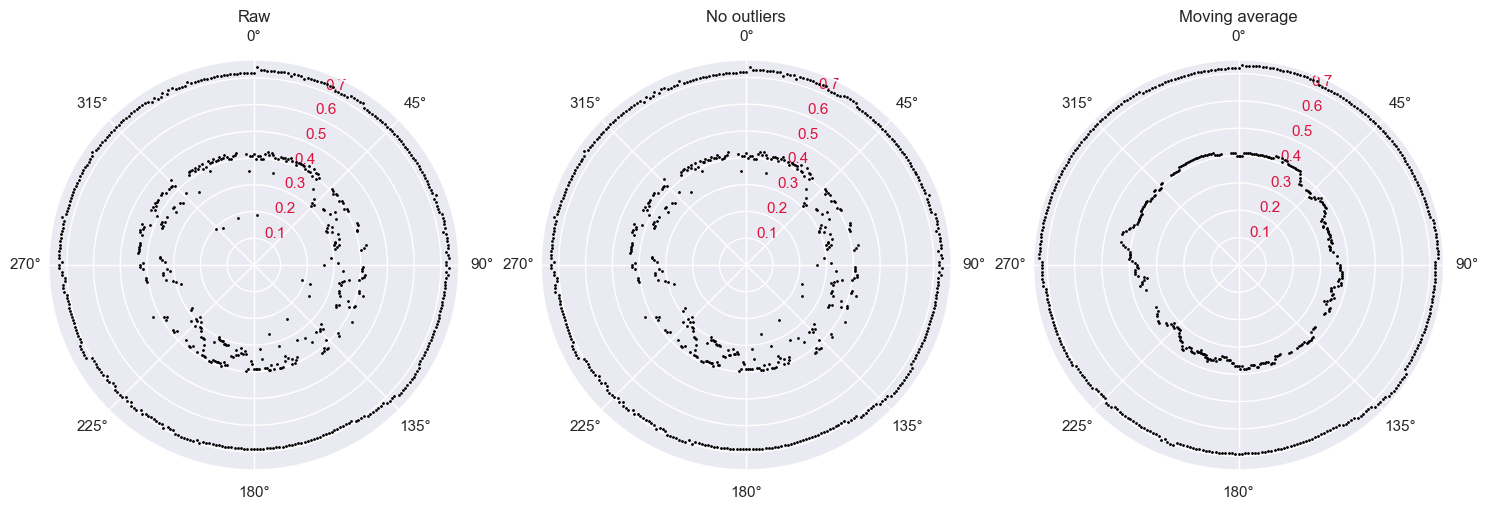

In [421]:
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'))

ax[0].plot(peak_rads_1D_12, peak_xpos_1D_12, linestyle = 'None',
         color='black', marker='.', markersize='2', markerfacecolor='black')
ax[0].set_theta_zero_location('N')
ax[0].set_theta_direction(-1) # clockwise
ax[0].grid(True)
ax[0].tick_params(axis='y', colors='crimson')
ax[0].set_title('Raw')

ax[1].plot(peak_rads_1D_12_no_outliers, peak_xpos_1D_12_no_outliers, linestyle = 'None',
         color='black', marker='.', markersize='2', markerfacecolor='black')
ax[1].set_theta_zero_location('N')
ax[1].set_theta_direction(-1) # clockwise
ax[1].grid(True)
ax[1].tick_params(axis='y', colors='crimson')
ax[1].set_title('No outliers')

ax[2].plot(peak_rads_1D_12_moving_average, peak_xpos_1D_12_moving_average, linestyle = 'None',
         color='black', marker='.', markersize='2', markerfacecolor='black')
ax[2].set_theta_zero_location('N')
ax[2].set_theta_direction(-1) # clockwise
ax[2].grid(True)
ax[2].tick_params(axis='y', colors='crimson')
ax[2].set_title('Moving average')

fig.set_size_inches(18,6)

# Bitmap

* Creates a position matrix containing measurements positioned according to angle and xpos. variable : points
* Connects given points based on proximity. Various measures are taken to ensure that the program does full loops, i.e., the outer and inner loop.
* A bespoke flood fill program is used on the poisition matrix. This identifies the material of the cross section. 

The speed of this process is dependant largely on the bitmap_scale variable, which defines the resolution of the bitmap. 

In [422]:
#Bitmap variables.  

bitmap_scale = 600   #resolution of bitmap
reroll_lim = 40      #reroll limit - how many times a random point is picked and the script is run. Typically <10 is fine, but is higher for peace of mind. 

In [423]:
bm_x = []
bm_y = []
peak_rads_1D_12_moving_average[:] = [i - ((np.pi)/2) for i in peak_rads_1D_12_moving_average]
for rad, xpos in zip(peak_rads_1D_12_moving_average, peak_xpos_1D_12_moving_average):
    x = (((xpos * math.sin(rad))*bitmap_scale)/2) + (bitmap_scale/2)  
    y = (((xpos * math.cos(rad))*bitmap_scale)/2) + (bitmap_scale/2)
    bm_x.append(x)
    bm_y.append(y)
bm_x = np.rint(bm_x)
bm_y = np.rint(bm_y)

#removes dupes and rounds
points = np.column_stack((bm_x, bm_y))
points = np.unique(points, axis=0)
points = np.round(points).astype(int)

def rand_row(array): #finds a random row (outputs row vals. - not index)
    random_index = np.random.randint(0, len(array))
    return array[random_index]

def find_common_points(array1, array2):
    common = np.intersect1d(array1.view([('', array1.dtype)]*array1.shape[1]), 
                            array2.view([('', array2.dtype)]*array2.shape[1]))
    return common.view(array1.dtype).reshape(-1, array1.shape[1])

def local_array(point, scale): #creates array of points surrounding a given point with scale. 
    scale = int(scale)

    lup = point.copy()
    lup[0] += scale
    lup[1] += scale
    rup = point.copy()
    rup[0] += -scale
    rup[1] += scale
    lbp = point.copy()
    lbp[0] += -scale
    lbp[1] += -scale
    rbp = point.copy()
    rbp[0] += scale
    rbp[1] += -scale
    points = np.vstack((lup, rup, lbp, rbp))

    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    min_x = int(min_x)
    max_x = int(max_x)
    min_y = int(min_y)

    top = np.column_stack((np.arange(int(min_x), int(max_x) + 1), np.full(max_x - min_x + 1, min_y)))
    bottom = np.column_stack((np.arange(int(min_x), int(max_x) + 1), np.full(max_x - min_x + 1, max_y)))
    left = np.column_stack((np.full(int(max_y) - int(min_y) + 1, int(min_x)), np.arange(int(min_y), int(max_y) + 1)))
    right = np.column_stack((np.full(int(max_y) - int(min_y) + 1, int(max_x)), np.arange(int(min_y), int(max_y) + 1)))
    perimeter_points = np.vstack((top, right, bottom, left))
    perimeter_points = np.unique(perimeter_points, axis=0)
    return perimeter_points

def remove_shared_rows(array1, array2):
    mask = ~np.any(np.all(array1[:, None] == array2, axis=-1), axis=-1)
    return array1[mask]

def midpoints(p1, p2, scale): #produces rounded points between two points at increments
    #print('\np1:',p1, '\n& type:', type(p1))
    #print('\np2:',p2, '\n& type:', type(p2))
    x_range = np.round(np.linspace(p1[0], p2[0], scale)).astype(int)
    y_range = np.round(np.linspace(p1[1], p2[1], scale)).astype(int)
    points = np.unique(np.column_stack((x_range, y_range)), axis=0)
    return points


points_dec = points.copy() #monitors remaining points
invisible_array = [] #invisible array with points + intepolation points. 
scale_lim = int(bitmap_scale/15) #limit on thhe distance between points. 
reroll_counter = 0
obj_point_ = []
obj_point_ls = []
obj_point_np = []
common_points = []
first_pos=np.empty((0,2))
start1 = time.time()

while len(points_dec) > 0 and reroll_counter < reroll_lim:
    #reroll section
    del obj_point_, obj_point_np
    obj_point_ = rand_row(points_dec)
    obj_point_np = obj_point_.ravel()
    invisible_array.append(obj_point_np)

    move_counter = 1
    reroll = 0
    while reroll == 0 and len(points_dec) > 0 and reroll_counter < reroll_lim:
        #next point section
        i = 1
        next_pos = 0
        while next_pos == 0 and reroll == 0 and len(points_dec) > 0 and reroll_counter < reroll_lim:
            #next area scale section
            del obj_point_ls, common_points
            obj_point_ls = np.array(obj_point_np).tolist()
            perimeter_points = local_array(obj_point_ls,i)
            common_points = find_common_points(points_dec, perimeter_points)
            if len(common_points) == 0:
                i += 1
                if i > scale_lim:
                    reroll_counter += 1
                    reroll = 1
            if len(common_points) > 0:
                if i > 1:
                    if move_counter < 3:
                        first_pos = np.vstack((first_pos,obj_point_np))
                    if move_counter == 5:
                        #reintroduce the initial position
                        points_dec = np.vstack((points_dec, first_pos))
                    for p in common_points:
                        mp_x = obj_point_ls[0]
                        mp_y = obj_point_ls[1]
                        mps = midpoints([mp_x,mp_y], p, i*10)
                        invisible_array.append(mps)
                    points_dec = remove_shared_rows(points_dec, obj_point_np)
                    if len(common_points) == 1:
                        obj_point_np = common_points
                        obj_point_np = obj_point_np.ravel()
                        move_counter += 1
                    if len(common_points) > 1:
                        obj_point_np = rand_row(common_points)
                        obj_point_np = obj_point_np.ravel()
                        move_counter += 1
                    next_pos = 1
                if i == 1:
                    if move_counter == 1:
                        first_pos = obj_point_np
                    if move_counter == 5:
                        #reintroduce the initial positions
                        points_dec = np.vstack((points_dec, first_pos))
                    points_dec = remove_shared_rows(points_dec, obj_point_np)
                    if len(common_points) == 1:
                        invisible_array.append(common_points)
                        obj_point_np = common_points
                        obj_point_np = obj_point_np.ravel()
                        move_counter += 1
                    if len(common_points) > 1:
                        for pp in common_points:
                            invisible_array.append(pp)
                        obj_point_np = rand_row(common_points)
                        obj_point_np = obj_point_np.ravel()
                        move_counter += 1
                    next_pos = 1
            
invisible_array = np.vstack(invisible_array) #makes homogenous
invisible_array = np.array(invisible_array) #makes np array
invisible_array = np.unique(invisible_array, axis=0) #removes copies

print('Reroll count:', reroll_counter,
       '\nInvisible array count:',len(invisible_array),
       '\nPoints remaining count:', len(points_dec))
end1 = time.time()
connect_time = end1 - start1
connect_time = str(round(connect_time, 3))
print('\nTime taken to connect:', connect_time, 's')

Reroll count: 40 
Invisible array count: 2764 
Points remaining count: 6

Time taken to connect: 0.682 s


In [424]:
#FILL SECTION
bitmap_centre = int(bitmap_scale/2)
brim = np.min([y for x, y in invisible_array if x == bitmap_centre])
brim_ext = brim + 15
brim_pos = np.array([brim_ext,bitmap_centre]).astype(int) #inital point

def diamond(pos_):
    pos_u = pos_.copy()
    pos_d = pos_.copy()
    pos_l = pos_.copy()
    pos_r = pos_.copy()
    pos_u[1] += 1 
    pos_d[1] -= 1
    pos_l[0] += 1
    pos_r[0] -= 1 
    return np.vstack((pos_u, pos_d, pos_l, pos_r))

fill_array = np.array([brim_pos])
investigation_set1 = diamond(brim_pos)
investigation_set2 = np.empty((0, 2))
for d in investigation_set1:
    p = diamond(d)
    investigation_set2 = np.vstack((investigation_set2,p))
investigation_set2 = remove_shared_rows(investigation_set2, investigation_set1)
investigation_set2 = remove_shared_rows(investigation_set2, brim_pos)
investigation_set2 = np.unique(investigation_set2, axis=0)

investigation_set3 = np.empty((0, 2))
start2 = time.time()
m = 0

#reduce the second requirement if the program wont finish during this loop
while len(investigation_set1) > 0 and m<3*bitmap_scale: 

    investigation_set3 = np.empty((0, 2))
    for p in investigation_set2:
        diamond_vals = diamond(p)
        investigation_set3 = np.vstack((investigation_set3, diamond_vals))

    investigation_set3 = np.unique(investigation_set3, axis=0)
    investigation_set3 = remove_shared_rows(investigation_set3, investigation_set1)
    investigation_set3 = remove_shared_rows(investigation_set3, invisible_array)

    fill_array = np.vstack((fill_array, investigation_set1))
    fill_array = np.unique(fill_array, axis=0)
    investigation_set1 = np.empty((0,2))
    investigation_set1 = np.copy(investigation_set2)
    investigation_set2 = np.empty((0,2))
    investigation_set2 = np.copy(investigation_set3)
    
    m += 1 


end2 = time.time()
fill_time = end2 - start2
fill_time = str(round(fill_time, 3))
print('Time taken to fill:   ', fill_time, 's\n')

Time taken to fill:    15.07 s



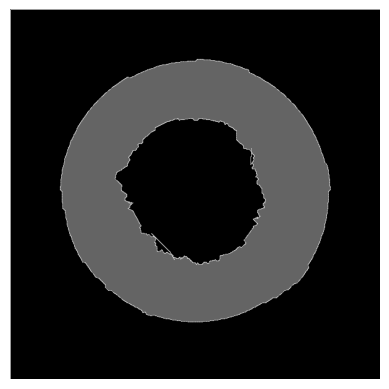

In [425]:
bitmap = np.zeros(((bitmap_scale), (bitmap_scale), 3), dtype=np.uint8)

dots = np.linspace(1, bitmap_scale, bitmap_scale, dtype =int)
for i in dots:
    if i < bitmap_scale:
        bitmap[i,0] = (255,255,255)
        bitmap[0,i] = (255,255,255)

#filled space
x_fill = fill_array[:, 0]
y_fill = fill_array[:, 1]
for x, y in zip(x_fill, y_fill): 
    x = int(x)
    y = int(y)
    bitmap[x,y] = (100, 100, 100) #RGB

 #connecting points
x_invis = invisible_array[:, 0]
y_invis = invisible_array[:, 1]
for x, y in zip(x_invis, y_invis):
    x = int(x)
    y = int(y)
    bitmap[x,y] = (180, 180, 180)

 #points
for x, y in zip(bm_x, bm_y):
    x = int(x)
    y = int(y)
    bitmap[x,y] = (255, 255, 255)

imgplot = plt.imshow(Image.fromarray(bitmap, 'RGB'))
plt.axis('off')
plt.show()